# Attitude estimation

We would like to track the drones state pitch and roll $\theta$, $\phi$ respectively. For each measurement, we would obtain the pitch and roll estimated from the accelerometer and the angular velocities from the gyro. 

$$
z_t =\begin{bmatrix} \theta \\ \phi \\ q \\ p  \end{bmatrix}
$$

For this exercise, we will assume that the drone is close to the hover mode. Thus $\phi \ll 1$ and $\theta \ll 1$. The advantage of the given assumption is that we can assume turning rate in body frame is the same as in the global frame.
$$
\dot{\phi} = p \\
\dot{\theta} = q
$$

**Note:** For larger angles, you have to use the transformation matrix which we covered in previous lessons. 
Our state will consist of the pitch and roll angles.
$$
x= \begin{bmatrix} \theta \\ \phi \end{bmatrix}
$$

### Filter architecture
We will combine the measurements of the pitch a roll angle from the accelerometer with the previously estimated pitch and roll plus angular velocities measured by gyroscopes. 

This is achieved by giving different weights for each measurement. 
$$
\hat{\theta}_t = \frac{\tau}{\tau + dt}\left( \hat{\theta}_{t-1} +  z_{t,\dot{\theta}} \times dt\right) + \frac{dt}{\tau + T_s} z_{t,\theta} \\ 
\hat{\phi}_t = \frac{\tau}{\tau + dt}\left( \hat{\phi}_{t-1} +  z_{t,\dot{\phi}} \times dt\right) + \frac{dt}{\tau + T_s} z_{t,\phi}
$$

Where $dt$ is a time interval between sampling, $\hat{\theta}_{t-1}$ and $\hat{\phi}_{t-1}$ represents the previously estimated values. By choosing the $\tau$ time constant we can assign different weights to the direct measurement of the pitch and roll from accelerometer  $z_{t,\theta}$ and $ z_{t,\phi}$, respectfully and the predicted values for pitch and roll from old estimated values $\left( \hat{\theta}_{t-1} +  z_{t,\dot{\theta}} \times dt\right)$ and $\left( \hat{\phi}_{t-1} +  z_{t,\dot{\phi}} \times dt\right)$. 

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
from math import sin, cos
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from ipywidgets import interactive
from scipy.stats import multivariate_normal
import pandas as pd 

pylab.rcParams['figure.figsize'] = 10, 10

In [2]:
pylab.rcParams['figure.figsize'] = 10, 10

Implementing the `AttitudeFilter` object.

In [3]:
class AttitudeFilter:
    def __init__(self,
                 dt,       # Time between sampling
                 tau       # The time constant dictating the weights       
                 ): 
        
        
        self.dt= dt
        self.tau = tau
        self.estimated_theta = 0.0
        self.estimated_phi   = 0.0
        
    def update(self,
               z           # z is observation which contains the theta, phi, q and p
               ):
        # TODO: implement the estimated pitch and roll 
        # self.estimated_theta = None
        # self.estimated_phi = None 
        
        self.estimated_theta = self.tau/(self.tau +self.dt) * (self.estimated_theta + z[2]*self.dt) + \
                               self.dt/(self.tau +self.dt) * z[0]

        self.estimated_phi = self.tau/(self.tau +self.dt) * (self.estimated_phi + z[3]*self.dt) + \
                             self.dt/(self.tau +self.dt) * z[1]


For this exercise, we will provide log data recorded by drone.

In [4]:
filename = "LoggedData1.csv"
data=pd.read_csv(filename)

Head of the data file displaying the first five rows.

In [5]:
data.head(n=5)

,Unnamed: 0,Time,stabilizer.roll,stabilizer.pitch,stabilizer.yaw,gyro.x,gyro.y,gyro.z
0,0,77269.0,0.427406,-0.813199,4.201566,-0.045085,0.039772,-0.020768
1,1,77279.0,0.425935,-0.812913,4.197217,0.002917,0.112274,-0.018669
2,2,77289.0,0.427015,-0.750879,4.192437,-0.080705,0.044952,0.126689
3,3,77299.0,0.427738,-0.830016,4.189671,0.043774,0.065536,0.069521
4,4,77309.0,0.429950,-0.889292,4.186883,0.025454,-0.061790,-0.031465


We will use the loaded data to create the measurement matrix and estimate the roll and pitch angles. 

### Creating the data

In [6]:
z=np.zeros((data.shape[0],4))
x=np.zeros((data.shape[0],2))
z[:,0] = data['stabilizer.pitch']
z[:,1] = data['stabilizer.roll']
z[:,2] = -data['gyro.y']
z[:,3] = data['gyro.x']
dt=10**(-2)                              # sec [Time between measurements]
tau = dt*5                               # Tau which is used to normalize the data 
t=(data['Time']-data['Time'][0])*dt

### Initialize the object

In [7]:
ComplementaryFilter = AttitudeFilter(dt,tau)

#At the initial point, we assume the estimated pitch and roll angles are the ones measured by accelerometer 
ComplementaryFilter.estimated_theta = z[0,0]
ComplementaryFilter.estimated_phi = z[0,1]

# X is the state vector for the complementary filter. 
x[0,0] = ComplementaryFilter.estimated_theta
x[0,1] = ComplementaryFilter.estimated_phi

y=np.zeros((data.shape[0],2))
y[0,0] = z[0,0]
y[:,0] = np.cumsum(z[:,2])*dt + y[0,0]

y[0,1] = z[0,1]
y[:,1] = np.cumsum(z[:,3])*dt + y[0,1]

Estimating the data based on the recorded information.

In [8]:
for i in range(1,data.shape[0]):
    ComplementaryFilter.update(z[i,:])
    x[i,0] = ComplementaryFilter.estimated_theta
    x[i,1] = ComplementaryFilter.estimated_phi

Plotting the measured and estimated roll and pitch.

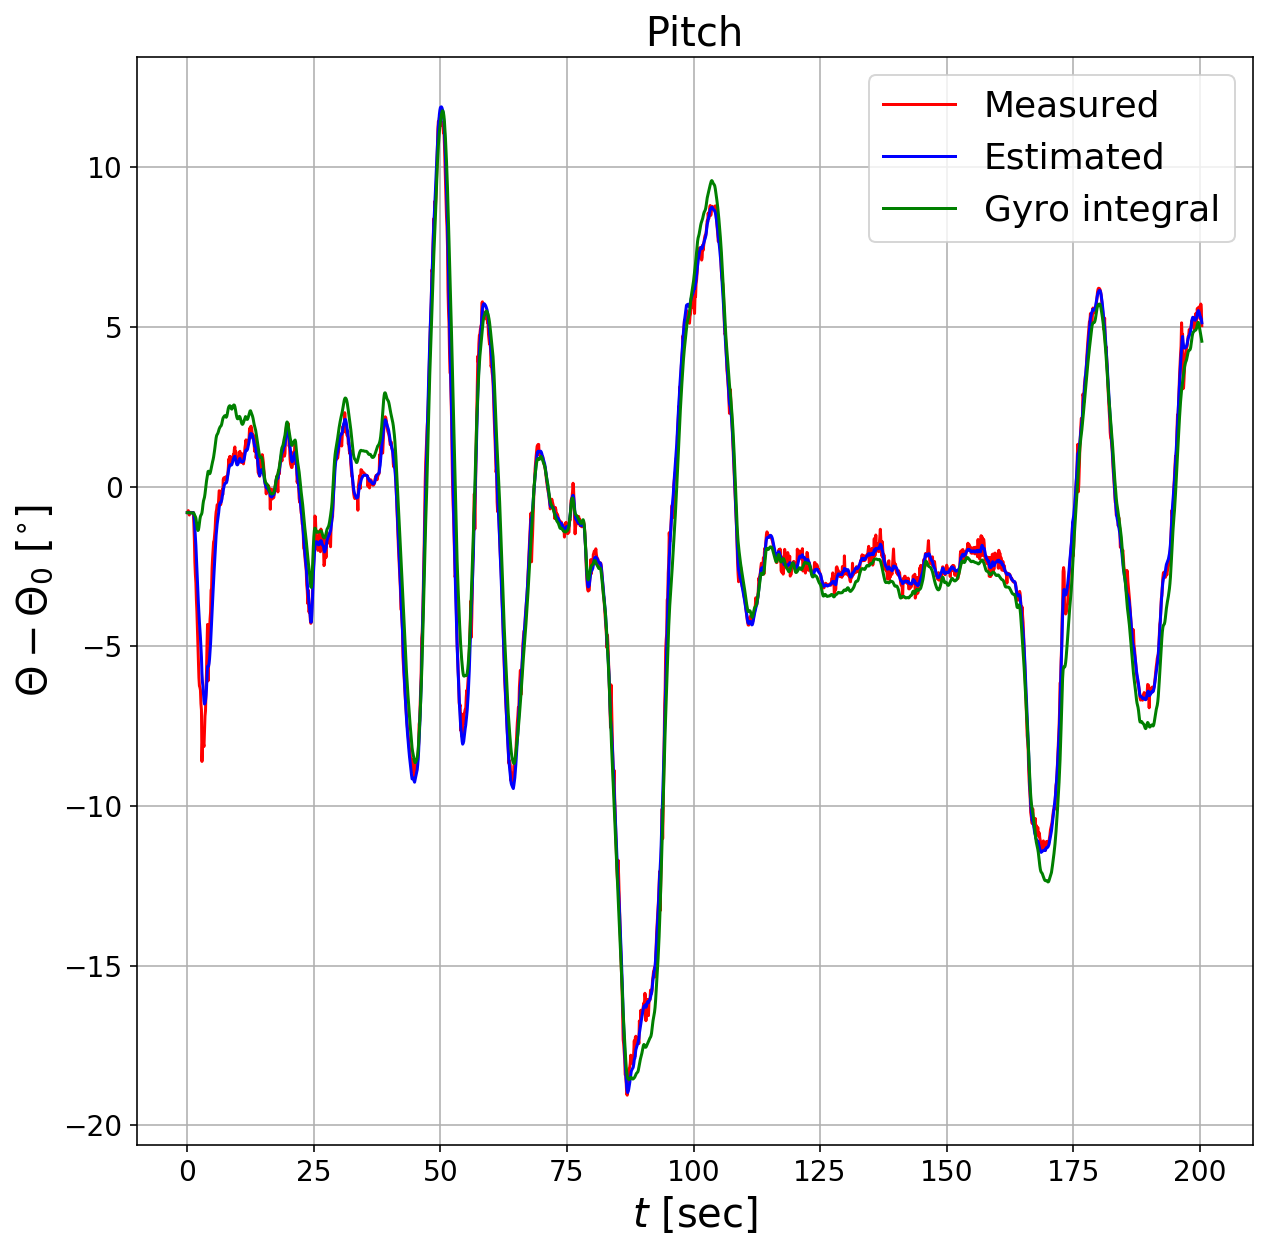

In [9]:
plt.plot(t,z[:,0],linestyle='-',color='red')
plt.plot(t,x[:,0],linestyle='-',color='blue')
plt.plot(t,y[:,0],linestyle='-',color='green')
plt.grid()
plt.title('Pitch').set_fontsize(20)
plt.xlabel('$t$ [sec]').set_fontsize(20)
plt.ylabel('$\Theta - \Theta_0$ [$^{\circ}$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Measured','Estimated','Gyro integral'],fontsize = 18)
plt.show()

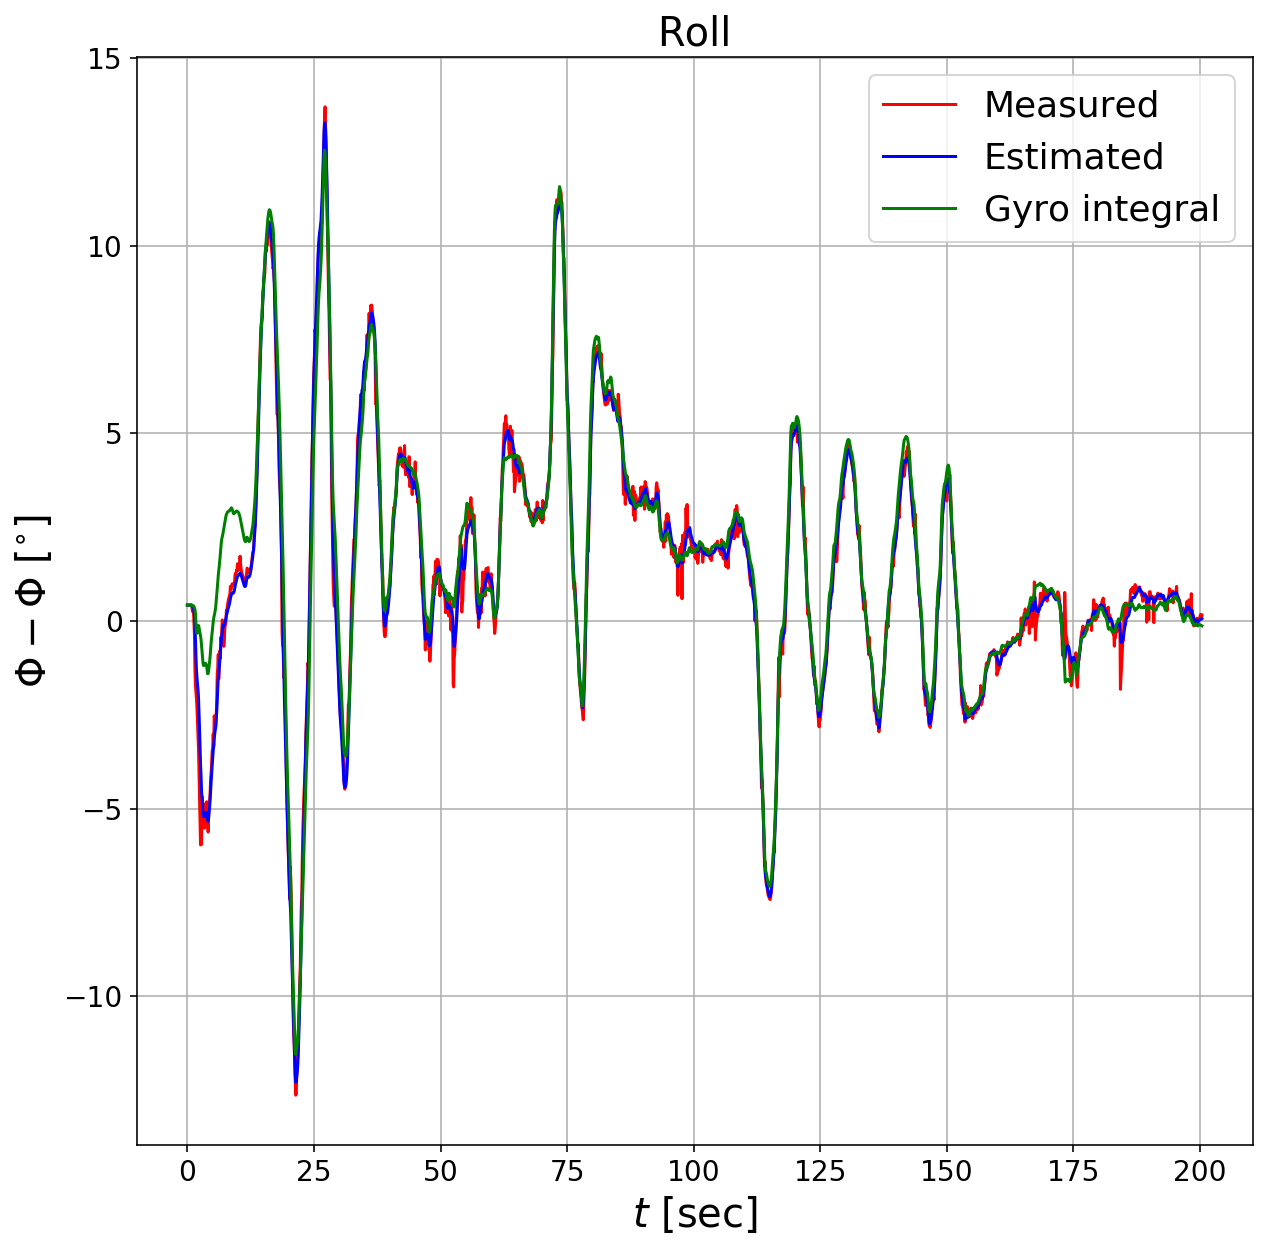

In [10]:
plt.plot(t,z[:,1],linestyle='-',color='red')
plt.plot(t,x[:,1],linestyle='-',color='blue')
plt.plot(t,y[:,1],linestyle='-',color='green')
plt.grid()
plt.title('Roll').set_fontsize(20)
plt.xlabel('$t$ [sec]').set_fontsize(20)
plt.ylabel('$\Phi - \Phi$ [$^{\circ}$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Measured','Estimated','Gyro integral'],fontsize = 18)
plt.show()